In [93]:
import glob
import json

examples = glob.glob("/plancraft/outputs/oracle_symb/*/0/*.json")
non_valid_ids = set()

for example in examples:
    data = json.load(open(example))
    if not data["success"]:
        non_valid_ids.add(data["example_id"])

print(len(non_valid_ids))

103


In [97]:
for dataset_name in glob.glob("data/*.json"):
    dataset = json.load(open(dataset_name))
    new_dataset = []
    for example in dataset:
        if example["id"] not in non_valid_ids:
            new_dataset.append(example)
    print(dataset_name, len(dataset), len(new_dataset))
    # replace
    json.dump(new_dataset, open(dataset_name, "w"), indent=2)

data/test.json 600 580
data/val.json 600 570
data/val.small.easy.json 100 100
data/train.json 1200 1147
data/test.small.json 120 117
data/val.small.json 120 110
data/test.small.easy.json 100 100


### Download outputs from wandb

In [77]:
import wandb
from tqdm import tqdm

project = "plancraft"
entity = "itl"

api = wandb.Api()
runs = api.runs(f"{entity}/{project}")

# download all 
for run in tqdm(runs):
    for file in run.files():
        if (
            file.name.startswith("outputs/")
            and file.name.endswith(".json")
            and "/val.small/" in file.name
            and "stp80" not in file.name
        ):
            file.download(exist_ok=True)

100%|██████████| 164/164 [03:21<00:00,  1.23s/it]


### Collate outputs into single results

In [98]:
import glob
import json

# load from local
task_results = glob.glob("outputs/*act*/*/*/*.json")
results = []

for task_result in task_results:
    example_id = task_result.split("/")[-1]
    seed = task_result.split("/")[-2]
    split = task_result.split("/")[-3]
    run_name = task_result.split("/")[-4]
    with open(task_result) as f:
        result = json.load(f)

    result["name"] = run_name
    result["split"] = split
    result["seed"] = seed

    results.append(result)

In [106]:
import pandas as pd

df = pd.DataFrame(results)
# df.model_trace.apply(pd.Series)
df = pd.concat([df, df.model_trace.apply(pd.Series)], axis=1).drop(
    "model_trace", axis=1
)
df = df[~df.example_id.isin(non_valid_ids)]

df["name"] = df["name"].str.replace("_symb_Meta-Llama-3.1-8B-Instruct", "")
df["tools"] = df["name"].str.split("_").str[-1]
df["mode"] = df["name"].str.split("_").str[0]

In [105]:
df.groupby(["name"]).tokens_used.sum() / 1000000 / 3 * 0.15

name
act_symb_Meta-Llama-3.1-8B-Instruct_move|smelt                               61.758259
act_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think                         96.632393
act_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think|search                  82.943473
act_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think|search|impossible       40.520209
react_symb_Meta-Llama-3.1-8B-Instruct_move|smelt                            126.184620
react_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think                      131.344576
react_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think|search               139.631777
react_symb_Meta-Llama-3.1-8B-Instruct_move|smelt|think|search|impossible     77.132472
Name: tokens_used, dtype: float64

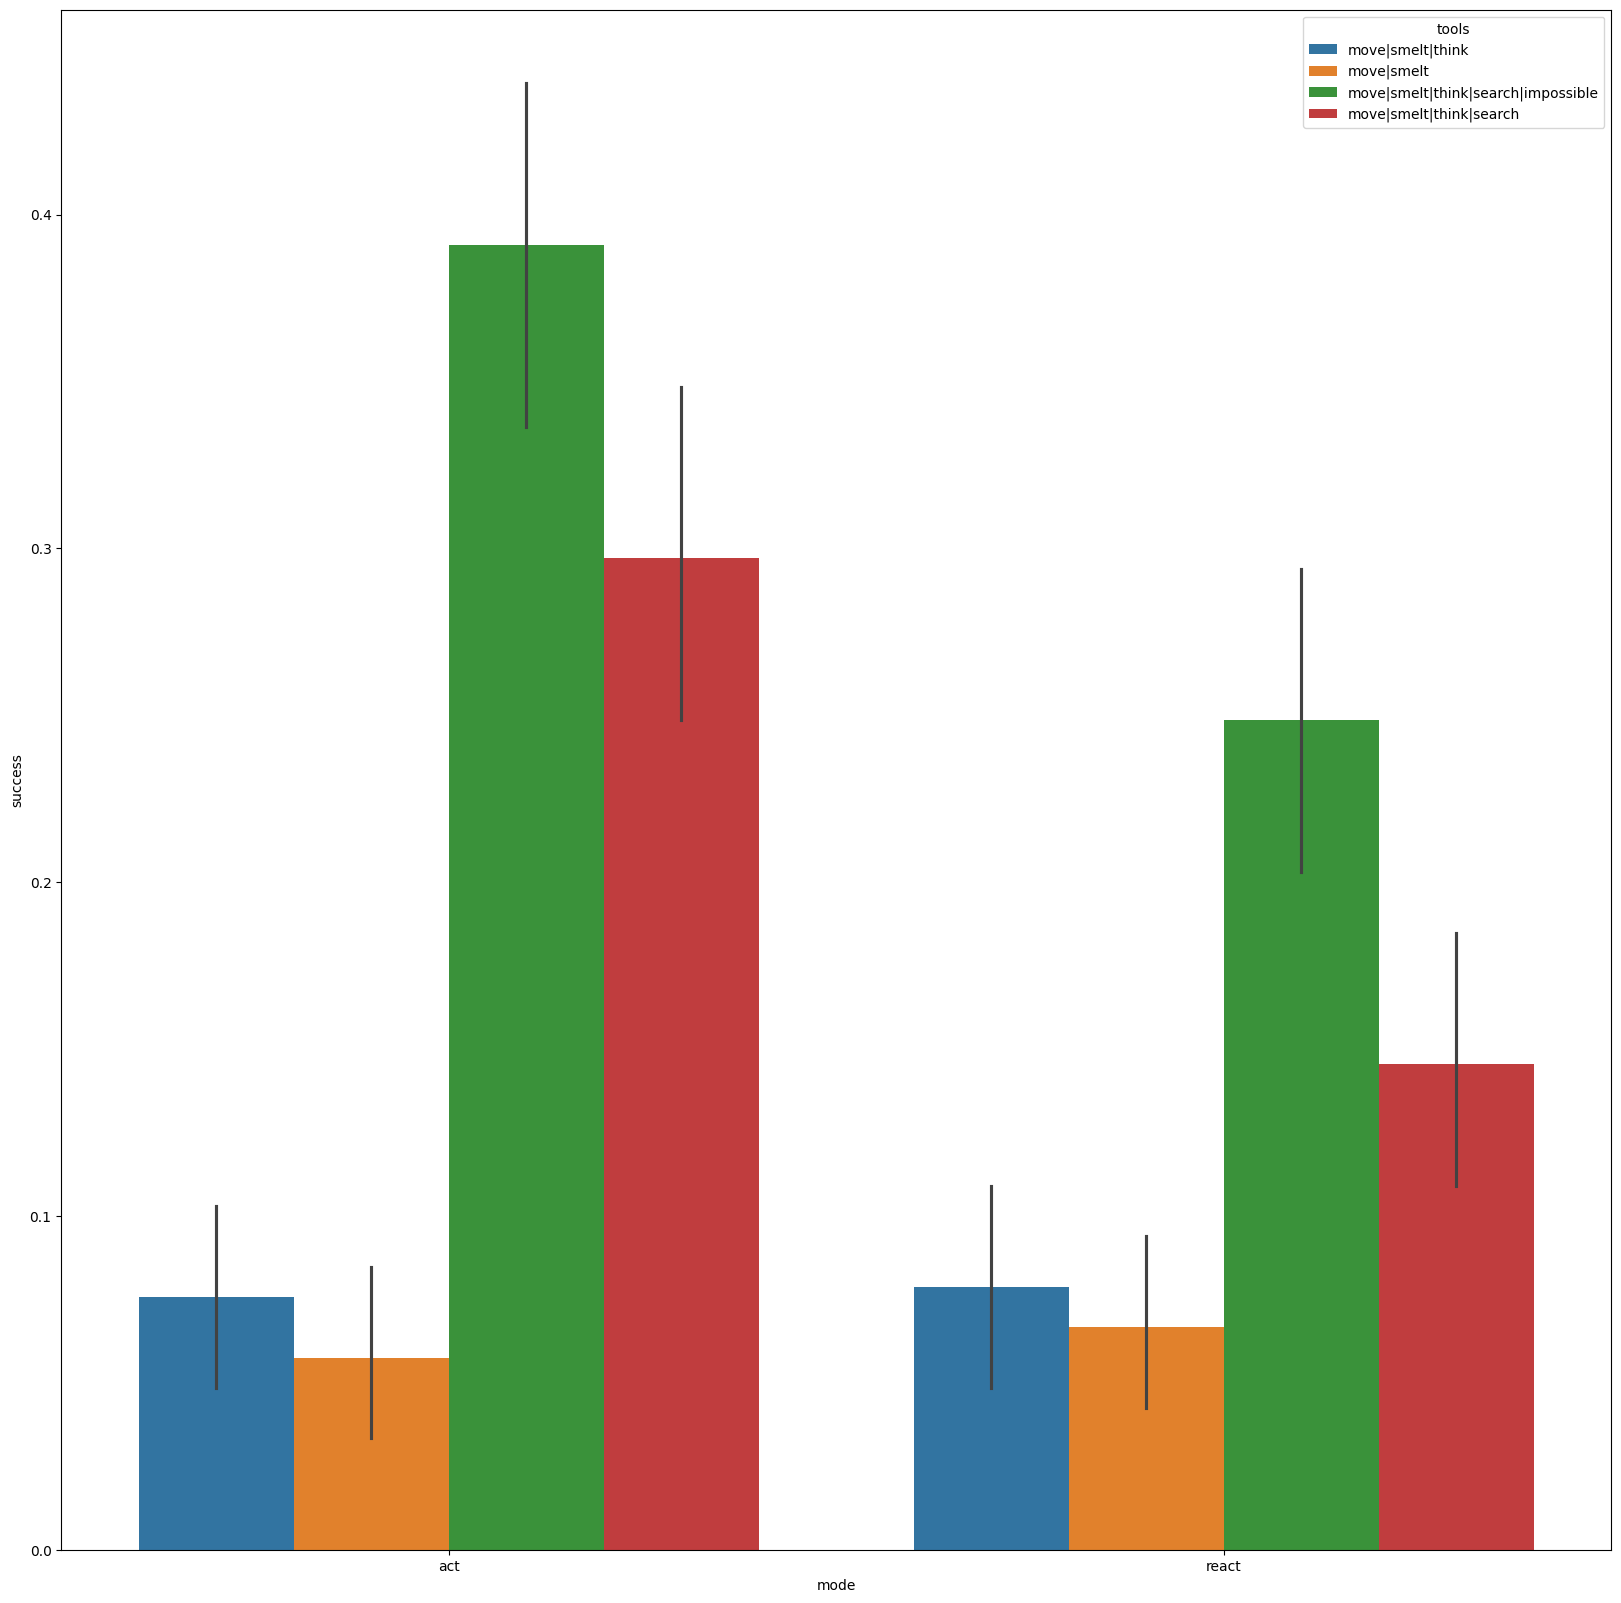

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(data=df, x="mode", y="success", hue="tools")
# rotate x labels
# plt.xticks(rotation=45)
plt.show()
